In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d odins0n/ucf-crime-dataset

100% 11.0G/11.0G [09:19<00:00, 22.0MB/s]
100% 11.0G/11.0G [09:20<00:00, 21.1MB/s]


In [ ]:
!unzip ucf-crime-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,MaxPooling2D,Conv2D,Flatten
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

train_dir = "/content/Train"
test_dir = "/content/Test"
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
INPUT_SHAPE=(64, 64, 3)
IMG_SHAPE = (64, 64)
BATCH_SIZE = 500
EPOCHS = 6
LR = 0.00003

crime_types =os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


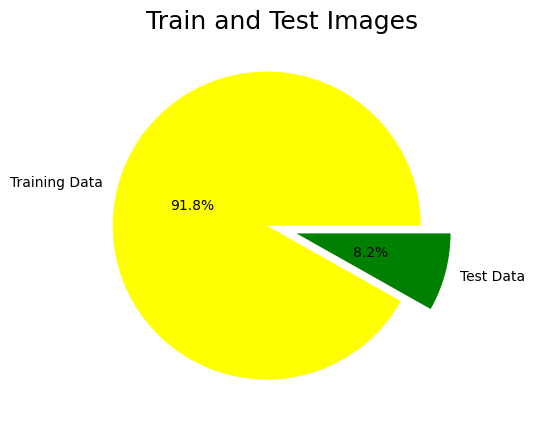

In [ ]:
crimes={}
train=test=0
for clss in crime_types:
  num=len(os.listdir(os.path.join(train_dir,clss)))
  train+=num
  test+=len(os.listdir(os.path.join(test_dir,clss)))
  crimes[clss]=num
plt.figure(figsize=(8,5))
plt.pie(x=np.array([train,test]),autopct="%.1f%%" , explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5, colors=["yellow", "green"])
plt.title("Train and Test Images", fontsize=18);

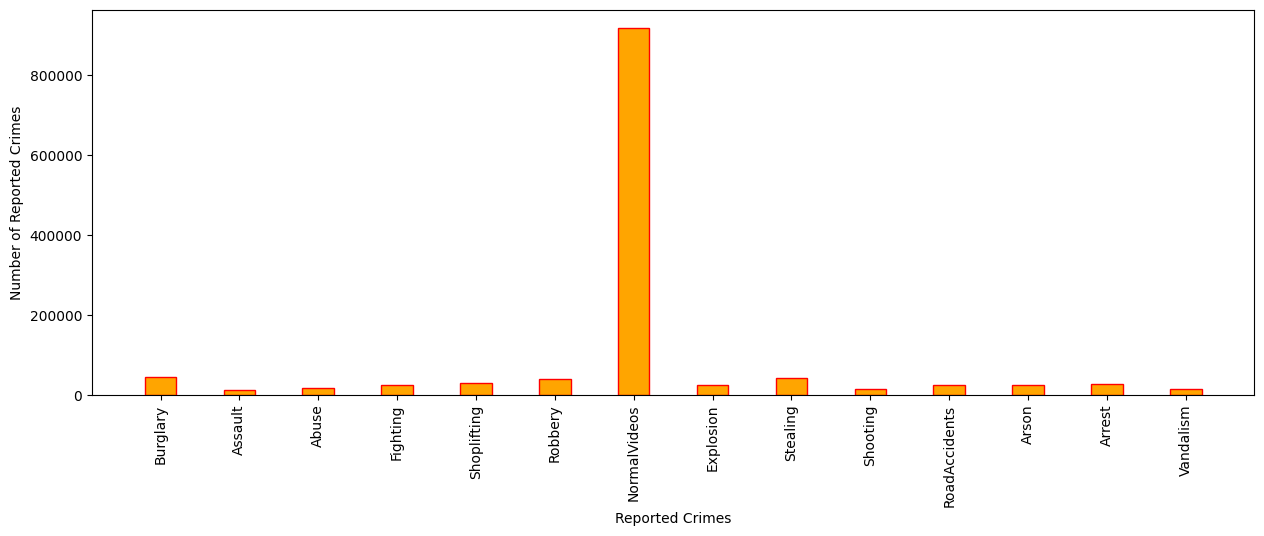

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4,align="center",edgecolor=['red'],color=['orange'])
plt.xticks(rotation=90)
plt.xlabel("Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()

In [ ]:
train_set=image_dataset_from_directory(
  train_dir,
  label_mode="categorical",
  batch_size=BATCH_SIZE,
  image_size=IMG_SHAPE,
  shuffle=True,
  seed=SEED,
  validation_split=0.2,
  subset="training",
)

Found 1251012 files belonging to 14 classes.
Using 1000810 files for training.


In [ ]:
val_set=image_dataset_from_directory(
train_dir,
label_mode="categorical",
batch_size=BATCH_SIZE,
image_size=IMG_SHAPE,
shuffle=True,
seed=SEED,
validation_split=0.2,
subset="validation",
)


Found 1251012 files belonging to 14 classes.
Using 250202 files for validation.


In [ ]:
test_set=image_dataset_from_directory(
test_dir, 
label_mode="categorical",
image_size=IMG_SHAPE,
shuffle=False,
class_names=None,
batch_size=BATCH_SIZE,
seed=SEED,
)

Found 111308 files belonging to 14 classes.


In [ ]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE, weights="imagenet")
    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False
    for layers in base_model.layers[thr:]:
        layers.trainable=False
    return base_model

In [ ]:
def create_model():
    model=Sequential()
    base_model=transfer_learning()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense (256, activation="relu"))
    model.add(Dropout (0.2))
    model.add(Dense (512, activation="relu"))
    model.add(Dropout (0.2))
    model.add(Dense (1024, activation="relu"))
    model.add(Dense (n, activation="softmax"))
    model.summary()
    return model

In [ ]:
model=create_model()

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

29084464/29084464 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [ ]:
history = model.fit(x = train_set, validation_data=val_set, epochs = 5)

Epoch 1/5
2002/2002 [==============================] - 1220s 597ms/step - loss: 0.3845 - accuracy: 0.9001 - val_loss: 0.0999 - val_accuracy: 0.9747
Epoch 2/5
2002/2002 [==============================] - 1118s 557ms/step - loss: 0.1431 - accuracy: 0.9580 - val_loss: 0.0578 - val_accuracy: 0.9846
Epoch 3/5
2002/2002 [==============================] - 1131s 563ms/step - loss: 0.1100 - accuracy: 0.9678 - val_loss: 0.0466 - val_accuracy: 0.9876
Epoch 4/5
2002/2002 [==============================] - 1177s 586ms/step - loss: 0.0943 - accuracy: 0.9726 - val_loss: 0.0365 - val_accuracy: 0.9902
Epoch 5/5
2002/2002 [==============================] - 1140s 568ms/step - loss: 0.0845 - accuracy: 0.9758 - val_loss: 0.0316 - val_accuracy: 0.9914


In [ ]:
model.save('crime.h5')

In [ ]:
from tensorflow.keras.models import load_model
model.load_weights('crime.h5')
y_true = np.array([])
for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax (y.numpy(), axis=-1)])

In [ ]:
y_pred=model.predict(test_set)

372/372 [==============================] - 41s 110ms/step


In [ ]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# List of image file paths
image_paths = [
'/content/Test/Explosion/Explosion046_x264_9720.png',
'/content/Test/Stealing/Stealing096_x264_2510.png',
'/content/Test/Explosion/Explosion046_x264_94020.png',
'/content/Test/NormalVideos/Normal_Videos642_x264_5170.png',
'/content/Test/Abuse/Abuse042_x264_19150.png',
]

# Load images and preprocess them
images = []
for path in image_paths:
    img = image.load_img(path, target_size=(64, 64))
    img = img.resize((64, 64))
    img = image.img_to_array(img)
    images.append(img)

# Convert images list to a NumPy array
images = np.array(images)

# Preprocess the images (normalize, etc.) if necessary
# ...

# Predict the labels for the images
predictions = model.predict(images)

# Get the predicted class indices
predicted_indices = np.argmax(predictions, axis=1)

# List of class names
class_names = ["Abuse", "Arrest", "Arson", "Assault", "Burglary", "Explosion", "Fighting", "NormalVideos", "RoadAccidents", "Robbery", "Shooting", "Shoplifting", "Stealing", "Vandalism"]

# Get the predicted class labels
predicted_labels = [class_names[idx] for idx in predicted_indices]

# Display the predictions
for i in range(len(image_paths)):
    print(f"Image: {image_paths[i]} - Predicted label: {predicted_labels[i]}")

1/1 [==============================] - 0s 83ms/step
Image: /content/Test/Explosion/Explosion046_x264_9720.png - Predicted label: Explosion
Image: /content/Test/Stealing/Stealing096_x264_2510.png - Predicted label: Stealing
Image: /content/Test/Explosion/Explosion046_x264_94020.png - Predicted label: Explosion
Image: /content/Test/NormalVideos/Normal_Videos642_x264_5170.png - Predicted label: NormalVideos
Image: /content/Test/Abuse/Abuse042_x264_19150.png - Predicted label: Abuse


In [9]:
import numpy as np
import tensorflow as tf
model = tf.keras.models.load_model('/content/crime.h5')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [11]:
!tar -zcvf ibm_crime-classification.tgz crime.h5

crime.h5


In [12]:
!pip install watson-machine-learning-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.9/538.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.7/971.7 kB 45.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.0 MB/s eta 0:00:00
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.13.0-py3-none-any.whl size=73917 sha256=8b5d43cdb5edf8be437d6fb1fed2eafd55de2

In [13]:
!pip install ibm_watson_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.2 MB/s eta 0:00:00


In [14]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"GKxTOBoNgY5dRNweS-yNNfY7SCE8FrwoHYOtiPVva_cV"
}

In [15]:
client = APIClient(wml_credentials)

In [16]:
client

In [18]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -------------  ------------------------
ID                                    NAME           CREATED
c99fab37-49d9-4261-bb1b-d589c710c333  crime-project  2023-05-21T05:14:28.091Z
------------------------------------  -------------  ------------------------


,ID,NAME,CREATED
0,c99fab37-49d9-4261-bb1b-d589c710c333,crime-project,2023-05-21T05:14:28.091Z


In [19]:
space_uid = "c99fab37-49d9-4261-bb1b-d589c710c333"
space_uid

'c99fab37-49d9-4261-bb1b-d589c710c333'

In [20]:
client.set.default_space(space_uid)

'SUCCESS'

In [42]:
client.software_specifications.list(limit=150)

-------------------------------  ------------------------------------  ----  ------------------  --------------------------
NAME                             ID                                    TYPE  STATE               REPLACEMENT
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base  unsupported         runtime-22.2-py3.10
autoai-ts_rt23.1-py3.10          01ce9391-1a79-5a33-94fb-2e134337f314  base  not_provided
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base  not_provided
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base  not_provided
tensorflow_rt23.1-py3.10         079a91e0-245f-5269-8926-3c20b28f37dc  base  not_provided
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base  unsupported         runtime-22.2-py3.10
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base  unsupported
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base  create-

,NAME,ID,TYPE,STATE,REPLACEMENT
0,default_py3.6,0062b8c9-8b7d-44a0-a9b9-46c416adcbd9,base,unsupported,runtime-22.2-py3.10
1,autoai-ts_rt23.1-py3.10,01ce9391-1a79-5a33-94fb-2e134337f314,base,not_provided,
2,kernel-spark3.2-scala2.12,020d69ce-7ac1-5e68-ac1a-31189867356a,base,not_provided,
3,pytorch-onnx_1.3-py3.7-edt,069ea134-3346-5748-b513-49120e15d288,base,not_provided,
4,tensorflow_rt23.1-py3.10,079a91e0-245f-5269-8926-3c20b28f37dc,base,not_provided,
...,...,...,...,...,...
103,runtime-22.2-r4.2,ec0a3d28-08f7-556c-9674-ca7c2dba30bd,base,supported,
104,tensorflow_rt22.2-py3.10,f65bd165-f057-55de-b5cb-f97cf2c0f393,base,supported,
105,do_20.1,f686cdd9-7904-5f9d-a732-01b0d6b10dc5,base,supported,
106,scikit-learn_0.19-py3.6,f963fa9d-4bb7-5652-9c5d-8d9289ef6ad9,base,unsupported,runtime-22.2-py3.10


In [38]:
software_space_uid = client.software_specifications.get_uid_by_name("runtime-22.2-py3.10")
software_space_uid

'b56101f1-309d-549b-a849-eaa63f77b2fb'

In [45]:
model_details = client.repository.store_model(model="ibm_crime-classification.tgz", meta_props={
    client.repository.ModelMetaNames.NAME:"crime",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.9",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})

In [46]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'software_spec': {'id': 'b56101f1-309d-549b-a849-eaa63f77b2fb',
   'name': 'runtime-22.2-py3.10'},
  'type': 'tensorflow_2.9'},
 'metadata': {'created_at': '2023-05-21T05:45:33.757Z',
  'id': 'b57634a2-9413-44ab-99a8-37f920b15920',
  'modified_at': '2023-05-21T05:45:38.534Z',
  'name': 'crime',
  'owner': 'IBMid-6670011MT6',
  'resource_key': '154b407c-3827-486c-9754-64d346872ab1',
  'space_id': 'c99fab37-49d9-4261-bb1b-d589c710c333'},
 'system': {'warnings': []}}

In [47]:
model_id = client.repository.get_model_id(model_details)
model_id

'b57634a2-9413-44ab-99a8-37f920b15920'

In [48]:
client.repository.download(model_id,'ibm-crime_classify.tgz')

Successfully saved model content to file: 'ibm-crime_classify.tgz'


'/content/ibm-crime_classify.tgz'